# Monte Carlo simulations for space systems reliability

## Introduction

An interesting application of the Monte Carlo method is the comparison of different system architectures and choosing the optimal one for a given mission. While comparisons can be made using analytical formulas, Monte Carlo simulations can indicate deviations from the expected behaviors and since they usually have a specified failure condition which is based on logic transitions, they enable the investigation of complex systems which have extremely complicated definitions for the reliability. In general, the reliability function $R(t)$ can be defined as the probability of a component/system not failing until the time step $t$. This is why reliability is also commonly defined as:

$$
R(t)=1-F(t)
$$

where $F(t)$ corresponds to the cumulative distribution function for the component/system. For electronic systems, the distribution which better interprets the data is the **exponential distribution**, resulting in:

$$
F(t)=\int_{0}^{t} f(x) d x=1-e^{-\lambda t}
$$

and finally 

$$
\mathrm{R}(\mathrm{t})=1-\mathrm{F}(\mathrm{t})=\mathrm{e}^{-\lambda t}
$$ 

which enables us to calculate the reliability of an electronic component at time $t$, given the failure rate $\lambda$ of the component.

## Space environment 

Space systems in Earth orbits are subject to different kinds of radiation environments. These include:

1. **Van Allen belts**
   - Trapped protons and electrons (internal belt)
   - Trapped electrons (external belt)
2. **Solar energetic particles** 
   - Electrons and protons/heavy ions (solar flares)
   - Protons and heavy ions (Coronal Mass Ejections)
3. **Cosmic galactic rays**
   - Protons and heavy ions
   
These particles can have a negative effect on systems operating in earth orbits. Specifically they can cause several types of damages, including:

1. Displacement damage
2. Total Ionizing dose damage
3. **Single Events**

In this assignment we are interested in single events, which due to their random nature can be modeled very accurately using Monte Carlo simulations so that we can compare architectures for a spacecraft's On-board processing system. Specifically, we will investigate micro-controller units and determine **which architecture is the most preferable at the orbit environment of the International Space Station**. The four architectures which we are going to compare are:

1. Single MCU 
2. Dual Redundant MCU
3. Triple Modular Redundancy with immune voter
4. Triple Modular Redundancy with non-immune voter

## OMERE/Failure rates due to radiation effects

WIP

## Random number generator

In order for us to conduct a Monte Carlo simulation, we need random numbers to determine the system's behavior. For convenience, these random numbers have to be distributed uniformly within the interval $[0,1]$. We will implement a dedicated random number generator using the linear repeat method (or the so called Linear congruential method). This random number generator is based on the general relationship:

$$
x_{n+1}=\left[a_{0} x_{n}+a_{1} x_{n-1}+\cdots+a_{j} x_{n-j}+b\right] \bmod M
$$

to simplify things, we will use the relationship:

$x_{n+1}=\left[a x_{n}+b\right] \bmod M$

where $M$ has to be a very large number (since we are using a 64 bit system we will use $M=2^{64}-1$), $a=1812433253$ and $b$ has to be an odd number. We will also check the behavior of our random number generator. An obvious downside is that since the generation of a new random number requires the previous one, the numbers are correlated (which is an issue for smaller values of $a$ and $M$.

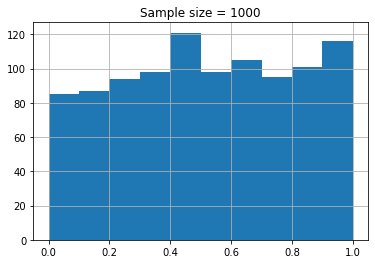

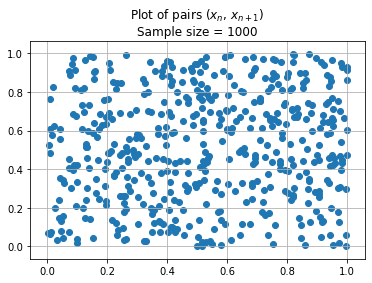

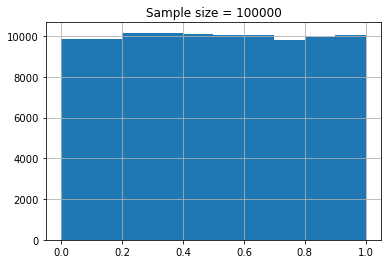

[0.2506476679042393, 0.25050892233902305, 0.2506513026382199, 0.2504787236977658, 0.2504478901170785]


In [11]:
import matplotlib.pyplot as plt
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def linear_congruential_generator(xn_prev, N):
    numbers_list = []
    for i in range(0, N):
        a = 1812433253
        M = pow(2, 64) - 1
        b = 89539
        xn_next = (a*xn_prev+b) % M
        numbers_list.append(xn_next/M)
        xn_prev = xn_next
    return numbers_list


numbers = 1000
result = linear_congruential_generator(0.02, numbers)
plt.figure()
plt.hist(result)
plt.title("Sample size = %d" % numbers)
plt.grid()

x_vector = [0.5]
y_vector = [0.0]
for i in range(0, numbers-1):
    if i == 0:
        y_vector[0] = result[i]
    elif i%2==0:
        y_vector.append(result[i])
    else:
        x_vector.append(result[i])

plt.figure()
plt.scatter(x_vector, y_vector)
plt.title("Plot of pairs ($x_{n}$, $x_{n+1}$)\nSample size = %d" % numbers)
plt.grid()
plt.show()

numbers = 100000
result = linear_congruential_generator(0.02, numbers)
plt.figure()
plt.hist(result)
plt.title("Sample size = %d" % numbers)
plt.grid()
plt.show()

c = []
for i in range(1, 6):
    sum = 0
    for j in range(0, numbers-i):
        sum += result[j]*result[j+i]
    c.append(sum/(j+1))

print(c)

There are two things to take away from this random number generator

1) By plotting ($x_{n}$, $x_{n+1}$) in pairs, no apparent correlation between points is apparent. Based only on this, we can conclude that our numbers are random.
2) However, if the random variables X and Y are independent and uniform in $[0, 1]$, then the mean for their product shall be:

$$
\langle x y\rangle=\int_{0}^{1} \int_{0}^{1} x y d x d y=\int_{0}^{1} x d x \int_{0}^{1} y d y=\frac{1}{4}
$$

which we can check by defining a sequence of random numbers ${x_i}$ and ${y_i}={x_{i+k}}$ and calculate the average 

$$
c(k)=\frac{1}{N} \sum_{i=1}^{N} x_{i} x_{i+k}, \quad k=1,2,3, \cdots
$$

Since we can observe that for all cases we have $c(k) \simeq \frac{1}{4}$ the numbers seem to be uncorrelated. But, since the error is higher than $\frac{1}{\sqrt{N}}$, there is an measurable correlation between our points. This is why we will refer to our numbers as pseudo-random.

## Case 1: Single MCU


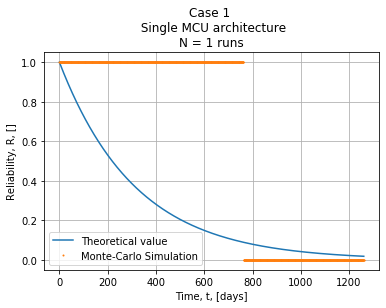

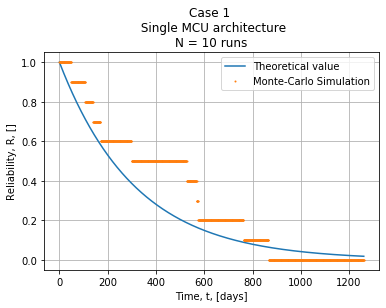

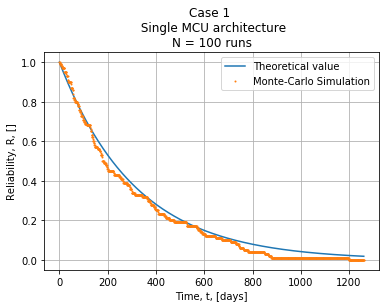

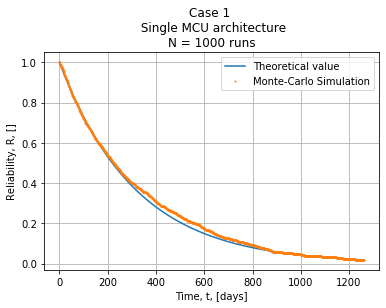

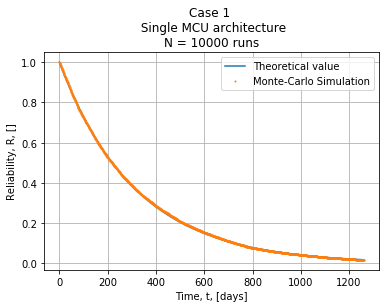

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from random_number_generators import linear_congruential_generator

# Reliability function definition
def reliability_function(time, mttf):
    return np.exp(-time / mttf)


def single_component(runs):
    # Input data
    lambda_MCU = 3.17 * pow(10, -3)  # [per day, OMERE data]
    MTTF_MCU = 1 / lambda_MCU  # [days]

    # Define time domain

    t_start = 0
    t_end = 4 * MTTF_MCU
    t_step = 1
    time_domain = np.arange(t_start, t_end, t_step)
    random_numbers = linear_congruential_generator(0.5, runs+1)

    # Calculate theoretical reliability at each time step
    theoretical_reliability = []
    for i in range(0, np.size(time_domain)):
        theoretical_reliability.append(reliability_function(time_domain[i], MTTF_MCU))

    # Main Monte-Carlo Simulation
    failure_time = []
    working_devices = np.zeros(np.size(time_domain))
    for i in range(0, runs):
        random_value = random_numbers[i+1]
        for j in range(0, np.size(time_domain)):
            if theoretical_reliability[j] < random_value:
                failure_time.append(time_domain[j])
                break
            working_devices[j] += 1

    plt.figure()
    plt.plot(time_domain, theoretical_reliability, label="Theoretical value")
    plt.plot(time_domain, working_devices / runs, '.', markersize=2, label="Monte-Carlo Simulation")
    plt.xlabel("Time, t, [days]")
    plt.ylabel("Reliability, R, []")
    plt.title("Case 1 \n Single MCU architecture\nN = %d runs" % runs)
    plt.grid()
    plt.legend()
    plt.show()
    
# Number of experiment runs
runs = [1, 10, 100, 1000, 10000]
for i in range(0, np.size(runs)):
    single_component(runs[i])

## Case 2: Dual MCU (Hot Redundancy)

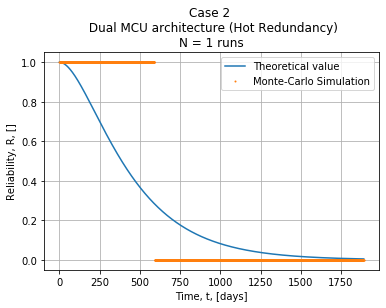

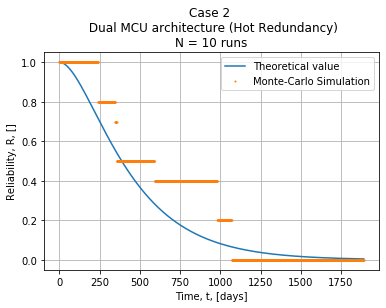

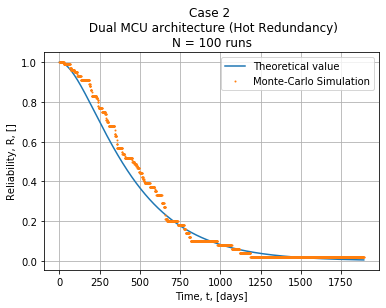

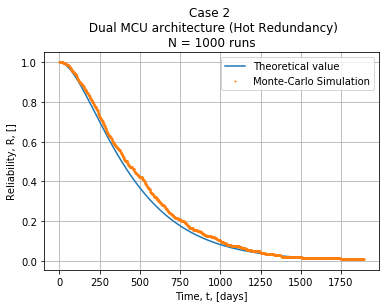

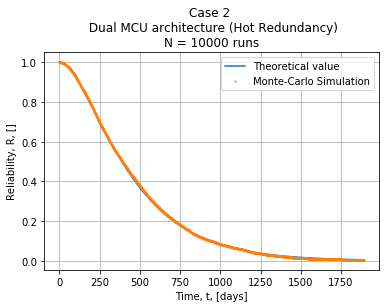

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from random_number_generators import linear_congruential_generator

# Reliability function definition
def system_reliability_function(time, mttf):
    return 1-((1-np.exp(-time / mttf))*(1-np.exp(-time / mttf)))


# Component reliability
def component_reliability_function(time, mttf):
    return np.exp(-time / mttf)


def dual_mcu(runs): 
    # Input data
    lambda_MCU = 3.17 * pow(10, -3)  # [per day, OMERE data]
    MTTF_MCU = 1 / lambda_MCU  # [days]

    # Define time domain

    t_start = 0
    t_end = 6 * MTTF_MCU
    t_step = 1
    time_domain = np.arange(t_start, t_end, t_step)
    random_numbers = linear_congruential_generator(0.862, runs+2)

    # Calculate theoretical reliability at each time step
    theoretical_system_reliability = []
    theoretical_component_reliability = []
    for i in range(0, np.size(time_domain)):
        theoretical_system_reliability.append(system_reliability_function(time_domain[i], MTTF_MCU))
        theoretical_component_reliability.append(component_reliability_function(time_domain[i], MTTF_MCU))

    # Main Monte-Carlo Simulation
    failure_time_system = []
    working_devices = np.zeros(np.size(time_domain))
    for i in range(0, runs):
        random_value_first = random_numbers[i+1]
        random_value_second = random_numbers[i+2]
        state_first_mcu = 1
        state_second_mcu = 1
        for j in range(0, np.size(time_domain)):
            if theoretical_component_reliability[j] < random_value_first:
                state_first_mcu = 0
            if theoretical_component_reliability[j] < random_value_second:
                state_second_mcu = 0
            if state_first_mcu == 0 and state_second_mcu == 0:
                failure_time_system.append(time_domain[j])
                break
            working_devices[j] += 1

    plt.figure()
    plt.plot(time_domain, theoretical_system_reliability, label="Theoretical value")
    plt.plot(time_domain, working_devices / runs, '.', markersize=2, label="Monte-Carlo Simulation")
    plt.xlabel("Time, t, [days]")
    plt.ylabel("Reliability, R, []")
    plt.title("Case 2 \n Dual MCU architecture (Hot Redundancy)\nN = %d runs" % runs)
    plt.grid()
    plt.legend()
    plt.show()
    

# Number of experiment runs
runs = [1, 10, 100, 1000, 10000]
for i in range(0, np.size(runs)):
    dual_mcu(runs[i])

## Case 3: Dual MCU (Cold Redundancy)

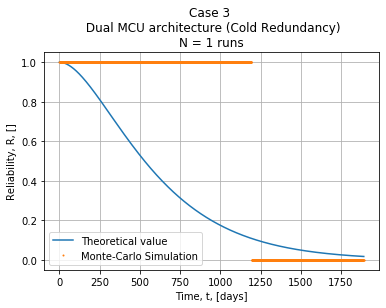

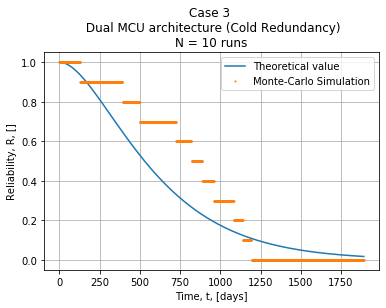

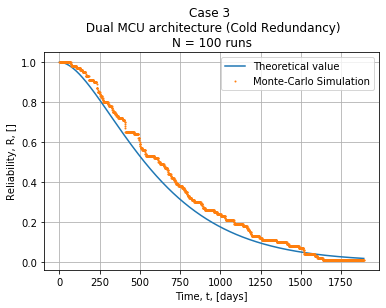

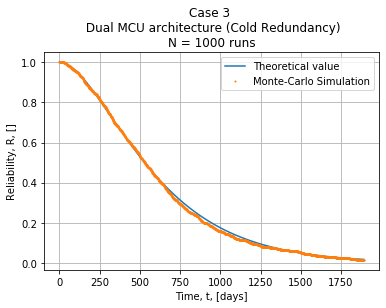

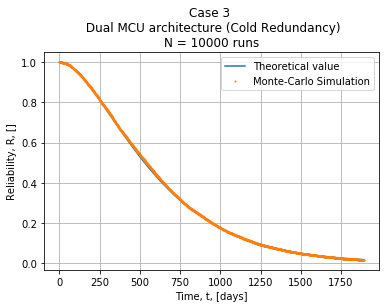

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from random_number_generators import linear_congruential_generator

# Reliability function definition
def system_reliability_function(time, mttf):
    return (np.exp(-time / mttf))+(np.exp(-time / mttf))*(time / mttf)


# Component reliability
def component_reliability_function(time, mttf):
    return np.exp(-time / mttf)

def dual_mcu(runs):
    random_numbers = linear_congruential_generator(0.742, runs+2)
    # Input data
    lambda_MCU = 3.17 * pow(10, -3)  # [per day, OMERE data]
    MTTF_MCU = 1 / lambda_MCU  # [days]

    # Define time domain

    t_start = 0
    t_end = 6 * MTTF_MCU
    t_step = 1
    time_domain = np.arange(t_start, t_end, t_step)

    # Calculate theoretical reliability at each time step
    theoretical_system_reliability = []
    theoretical_component_reliability = []
    for i in range(0, np.size(time_domain)):
        theoretical_system_reliability.append(system_reliability_function(time_domain[i], MTTF_MCU))
        theoretical_component_reliability.append(component_reliability_function(time_domain[i], MTTF_MCU))

    # Main Monte-Carlo Simulation
    failure_time_system = []
    working_systems = np.zeros(np.size(time_domain))
    for i in range(0, runs):
        random_value_first = random_numbers[i+1]
        random_value_second = random_numbers[i+2]
        state_first_mcu = 1
        state_second_mcu = 1
        for j in range(0, np.size(time_domain)):
            if theoretical_component_reliability[j] < random_value_first:
                for k in range(j, np.size(time_domain)):
                    if theoretical_component_reliability[k-j] < random_value_second:
                        failure_time_system.append(time_domain[k])
                        break
                    working_systems[k] += 1
                break
            working_systems[j] += 1

    plt.figure()
    plt.plot(time_domain, theoretical_system_reliability, label="Theoretical value")
    plt.plot(time_domain, working_systems / runs, '.', markersize=2, label="Monte-Carlo Simulation")
    plt.xlabel("Time, t, [days]")
    plt.ylabel("Reliability, R, []")
    plt.title("Case 3 \n Dual MCU architecture (Cold Redundancy)\nN = %d runs" % runs)
    plt.grid()
    plt.legend()
    plt.show()


# Number of experiment runs
runs = [1, 10, 100, 1000, 10000]
for i in range(0, np.size(runs)):
    dual_mcu(runs[i])